In [1]:
import re
import os
import time
import numpy as np
import pandas as pd
import unicodedata
import tensorflow as tf
import tensorflow.keras as krs
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import csv

BUFFER_SIZE = 20000
BATCH_SIZE = 64
embedding_dim = 50 # first it was 200

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install datasets

### Reading the data and droppping useless columns

In [4]:
# Load XSum dataset from Hugging Face datasets library
from datasets import load_dataset

dataset = load_dataset("xsum", "1.0.0")

# Select and preprocess a subset of the dataset (100 data points)
subset_size = 10
subset_dataset = dataset["train"].select(range(subset_size))

In [5]:
data = {"document": dataset["train"]["document"], "summary": dataset["train"]["summary"]}
df = pd.DataFrame(data)
df=df.head(10)
df

,document,summary
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...
5,Simone Favaro got the crucial try with the las...,Defending Pro12 champions Glasgow Warriors bag...
6,"Veronica Vanessa Chango-Alverez, 31, was kille...",A man with links to a car that was involved in...
7,Belgian cyclist Demoitie died after a collisio...,Welsh cyclist Luke Rowe says changes to the sp...
8,"Gundogan, 26, told BBC Sport he ""can see the f...",Manchester City midfielder Ilkay Gundogan says...
9,The crash happened about 07:20 GMT at the junc...,A jogger has been hit by an unmarked police ca...


In [6]:
summaries, longreview = pd.DataFrame(), pd.DataFrame()
summaries['short'] = df['summary']#[:data_to_use]
longreview['long'] = df['document']#[:data_to_use]
(summaries.shape,longreview.shape)

((10, 1), (10, 1))

### Cleaning the data for training

In [7]:
# replacing many abbreviations and lower casing the words
def clean_words(sentence):
    sentence = str(sentence).lower()
    sentence = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
    sentence = re.sub(r"http\S+","",sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r"'til", "until", sentence)
    sentence = re.sub(r"\"", "", sentence)
    sentence = re.sub(r"\'", "", sentence)
    sentence = re.sub(r' s ', "",sentence)
    sentence = re.sub(r"&39", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"&34", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]", "", sentence)
    sentence = re.sub(r"&", "", sentence)
    sentence = re.sub(r"\\n", "", sentence)
    sentence = sentence.strip()
    return sentence

In [8]:
summaries['short'] = summaries['short'].apply(lambda x: clean_words(x))
longreview['long'] = longreview['long'].apply(lambda x: clean_words(x))

In [9]:
longreview.head()

,long
0,the full cost of damage in newton stewart one ...
1,a fire alarm went off at the holiday inn in ho...
2,ferrari appeared in a position to challenge un...
3,john edward bates formerly of spalding lincoln...
4,patients and staff were evacuated from cerahpa...


In [10]:
# adding start and end token to the senteces of label
start_token, end_token = '<startseq>' , '<endseq>'
summaries = summaries.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
summaries["short"][5]

'<startseq> defending pro champions glasgow warriors bagged a late bonuspoint victory over the dragons despite a host of absentees and two yellow cards <endseq>'

In [11]:
val_split = 0.1
# train validation split
summaries_train = summaries[int(len(summaries)*val_split):]
summaries_val = summaries[:int(len(summaries)*val_split)]
longreview_train = longreview[int(len(summaries)*val_split):]
longreview_val = longreview[:int(len(summaries)*val_split)]

len(longreview_val),len(longreview_train)

(1, 9)

In [12]:
longreview_train.iloc[0], summaries_train.iloc[0]

(long    a fire alarm went off at the holiday inn in ho...
 Name: 1, dtype: object,
 short    <startseq> two tourist buses have been destroy...
 Name: 1, dtype: object)

finding the maximum length of questions and answers

In [13]:
# because there are senteces with unusually long lengths,
# we caculate the max length that 95% of sentences are shorter than that
def max_length(shorts, longs, prct):
    # Create a list of all the captions

    length_longs = list(len(d.split()) for d in longs)
    length_shorts = list(len(d.split()) for d in shorts)

    print('percentile {} of length of news: {}'.format(prct,np.percentile(length_longs, prct)))
    print('longest sentence: ', max(length_longs))
    print()
    print('percentile {} of length of summaries: {}'.format(prct,np.percentile(length_shorts, prct)))
    print('longest sentence: ', max(length_shorts))
    print()
    return int(np.percentile(length_longs, prct)),int(np.percentile(length_shorts, prct))

# selecting sentence length based on the percentile of data that fits in the length
max_len_news, max_len_summary= max_length(summaries_train['short'].to_list(), longreview_train['long'].to_list(), 90)


print('max-length longreview chosen for training: ', max_len_news)
print('max-length summaries chosen for training: ', max_len_summary)

percentile 90 of length of news: 605.0
longest sentence:  881

percentile 90 of length of summaries: 26.2
longest sentence:  27

max-length longreview chosen for training:  605
max-length summaries chosen for training:  26


### Dataset prepration


In [14]:
# making a vocabulary of the words
def create_vocab(shorts, longs = None, minimum_repeat = 3):

    # Create a list of all the captions
    all_captions = []
    for s in shorts:
        all_captions.append(s)

    # Consider only words which occur at least minimum_occurrence times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= minimum_repeat]

    vocab = list(set(vocab))
    return vocab

In [15]:
# each word in the vocabulary must be used in the data atleast minimum_repeat times
vocab_dec = create_vocab(longreview_train['long'].to_list(), minimum_repeat=3) # here we just use the words in vocabulary of summaries
# removing one character words from vocab except for 'a'
for v in vocab_dec:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_dec.remove(v)


vocab_dec = sorted(vocab_dec)[1:] # [1:] is for the ''
vocab_dec.append('<startseq>')
vocab_dec.append('<endseq>')
vocab_dec

['a',
 'about',
 'adding',
 'advantage',
 'after',
 'ahead',
 'alex',
 'all',
 'am',
 'an',
 'and',
 'another',
 'are',
 'as',
 'at',
 'audi',
 'back',
 'bates',
 'bbc',
 'be',
 'because',
 'been',
 'before',
 'behind',
 'being',
 'belgian',
 'between',
 'brew',
 'buses',
 'but',
 'by',
 'can',
 'car',
 'cars',
 'changoalverez',
 'city',
 'clegg',
 'cost',
 'could',
 'crash',
 'debut',
 'did',
 'died',
 'dragons',
 'driver',
 'during',
 'each',
 'earlier',
 'either',
 'end',
 'even',
 'experience',
 'fagerson',
 'family',
 'favaro',
 'feel',
 'final',
 'fire',
 'first',
 'following',
 'for',
 'force',
 'from',
 'fusaro',
 'game',
 'go',
 'going',
 'good',
 'got',
 'had',
 'hale',
 'hamilton',
 'happen',
 'has',
 'have',
 'he',
 'her',
 'hewitt',
 'him',
 'his',
 'home',
 'hospital',
 'how',
 'i',
 'if',
 'in',
 'injury',
 'investigation',
 'is',
 'it',
 'job',
 'jones',
 'jury',
 'knew',
 'know',
 'kutlubay',
 'landman',
 'last',
 'later',
 'league',
 'left',
 'lincolnshire',
 'london'

In [16]:
# each word in the vocabulary must be used in the data atleast minimum_repeat times
vocab_enc = create_vocab(longreview_train['long'].to_list(), minimum_repeat=3) # here we just use the words in vocabulary of summaries
# removing one character words from vocab except for 'a'
for v in vocab_enc:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_enc.remove(v)

vocab_enc = sorted(vocab_enc)[1:] # [1:] is for the ''
vocab_enc.append('<startseq>')
vocab_enc.append('<endseq>')
vocab_enc[:10]

['a',
 'about',
 'adding',
 'advantage',
 'after',
 'ahead',
 'alex',
 'all',
 'am',
 'an']

In [17]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
document_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
summary_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
document_tokenizer.fit_on_texts(vocab_enc)
summary_tokenizer.fit_on_texts(vocab_dec)#summaries_train['short'])

# caculating number of words in vocabulary of encoder and decoder
# they are important for positional encoding
encoder_vocab_size = len(document_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(210, 210)

In [18]:
ixtoword_enc = {} # index to word dic
ixtoword_dec = {} # index to word dic

wordtoix_enc = document_tokenizer.word_index # word to index dic
ixtoword_enc[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0
ixtoword_dec[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0

for w in document_tokenizer.word_index:
    ixtoword_enc[document_tokenizer.word_index[w]] = w
################################################
wordtoix_dec = summary_tokenizer.word_index # word to index dic

for w in summary_tokenizer.word_index:
    ixtoword_dec[summary_tokenizer.word_index[w]] = w

In [19]:
# assign a number to each word inorder to find it in word embeddings
inputs = document_tokenizer.texts_to_sequences(longreview_train['long'])
targets = summary_tokenizer.texts_to_sequences(summaries_train['short'])
inputs_val = document_tokenizer.texts_to_sequences(longreview_val['long'])
targets_val = summary_tokenizer.texts_to_sequences(summaries_val['short'])

In [20]:
inputs = krs.preprocessing.sequence.pad_sequences(inputs, maxlen=max_len_news, padding='post', truncating='post')
targets = krs.preprocessing.sequence.pad_sequences(targets, maxlen=max_len_summary, padding='post', truncating='post')
inputs_val = krs.preprocessing.sequence.pad_sequences(inputs_val, maxlen=max_len_news, padding='post', truncating='post')
targets_val = krs.preprocessing.sequence.pad_sequences(targets_val, maxlen=max_len_summary, padding='post', truncating='post')

In [21]:
# validate train split
BUFFER_SIZE = 10  # Equal to the dataset size
BATCH_SIZE = 2
dataset = tf.data.Dataset.from_tensor_slices((inputs,targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((inputs_val,targets_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE*2)

In [22]:
longreview_val.reset_index(inplace=True, drop=True)
summaries_val.reset_index(inplace=True, drop=True)
longreview_train.reset_index(inplace=True, drop=True)
summaries_train.reset_index(inplace=True, drop=True)

### Defining the model

In [23]:
import matplotlib.pyplot as plt

def hist(history):
    plt.title('Loss')

    x= [i[0] for i in history['val']]
    y=[i[1] for i in history['val']]
    plt.plot(x,y,'x-')

    x= [i[0] for i in history['train']]
    y=[i[1] for i in history['train']]
    plt.plot(x,y,'o-')


    plt.legend(['validation','train'])
    plt.show()
    print('smallest val loss:', sorted(history['val'],key=lambda x: x[1])[0])

#### Scaled Dot Product
![](files/z-score.png)


In [24]:
# the job of this function is to calculate the above equation
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### multi-headed attention
![](files/multi-head.png)

In [25]:
class MultiHeadAttention(krs.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # The dimensions of Q, K, V are called depth

        # the input of these 3 layers are the same: X
        self.wq = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wk = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wv = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))

        self.dense = tf.keras.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))

    # reshape the Q,K,V
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # learn the Q,K,V matrices (the layers' weightes)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # reshape them
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # the last dens layer expect one vector so we use concat
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

#### positional encoding

In [26]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

# The dimension of positional encodings is the same as
# the embeddings (d_model) for facilitating the summation of both.
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#### Layers

#### Embeddings preparation

In [27]:
 # Making the embedding mtrix
def make_embedding_layer(vocab_len, wordtoix, embedding_dim=200, glove=True, glove_path= '../glove'):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix
    else:
        print('Loading glove...')
        glove_dir = glove_path
        embeddings_index = {}
        #f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        f=open("/content/gdrive/MyDrive/glove.6B.50d.txt")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get n-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector

        print("GloVe ",embedding_dim, ' loaded!')

    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

embeddings_encoder = make_embedding_layer(encoder_vocab_size, wordtoix_enc, embedding_dim=embedding_dim, glove=True)
embeddings_decoder = make_embedding_layer(decoder_vocab_size, wordtoix_dec, embedding_dim=embedding_dim, glove=True)


Loading glove...
GloVe  50  loaded!
Loading glove...
GloVe  50  loaded!


#### transformer layers

In [28]:
# hyper-params
init_lr = 1e-3
lmbda_l2 = 0.1
d_out_rate = 0.1 # tested 0.4, 0.3, 0.1 values this 0.1 seems to be the best
num_layers = 4 # chaged from 4 to 5 to learn better
d_model = embedding_dim # d_model is the representation dimension or embedding dimension of a word (usually in the range 128–512)
dff = 512 # number of neurons in feed forward network
num_heads = 5 # first it was 8 i chenged it to 10 to use embd =300d

In [29]:
# The Point-wise feed-forward network block is essentially a
# two-layer linear transformation which is used identically throughout the model
def point_wise_feed_forward_network(d_model, dff):
    return krs.Sequential([
        krs.layers.Dense(dff, activation='relu',kernel_regularizer=krs.regularizers.l2(l=lmbda_l2)),
        krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    ])

In [30]:
class EncoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)

    # it has 1 layer of multi-headed attention
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [31]:
class DecoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
        self.dropout3 = krs.layers.Dropout(rate)

    # it has 2 layers of multi-headed attention
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [32]:
class Encoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_encoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = krs.layers.Dropout(rate)
        self.dropout_embd = krs.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x = self.dropout_embd(x, training=training) # dropout added to encoder input changed from nothing to this
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

In [33]:
class Decoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_decoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)] # a list of decoder layers
        self.dropout = krs.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask) # enc_output is fed into it

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

#### Final model

In [34]:
class Transformer(krs.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                                     target_vocab_size, pe_input, pe_target, rate=d_out_rate):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = krs.layers.Dense(target_vocab_size, kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))


    # training argument is used in dropout inputs
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [35]:
transformer = Transformer(
    num_layers,
    d_model,
    num_heads,
    dff,
    encoder_vocab_size,
    decoder_vocab_size,
    pe_input=max_len_news,
    pe_target=max_len_summary,
)

#### Masking


In [36]:
# Padding mask for masking "pad" sequences so
# they won't affect the loss
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# Lookahead mask for masking future words from
# contributing in prediction of current words in self attention
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [37]:
# this function is use in training step
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)

    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

#### training

In [38]:
lr_schedule = krs.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr, # originally was 1e-5
    decay_steps=4000, # approximately 5 epochs
    decay_rate=0.95) # originally was 0.9

In [39]:

optimizer2 = Adam(lr_schedule , beta_1=0.9, beta_2=0.98, epsilon=1e-9) # changed to init
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') # added softmax changed from_logits to false

In [40]:
def loss_function(real, pred, l2= False):

    if l2:
        lambda_ = 0.0001
        l2_norms = [tf.nn.l2_loss(v) for v in transformer.trainable_variables]
        l2_norm = tf.reduce_sum(l2_norms)
        l2_value = lambda_ * l2_norm
        loss_ = loss_object(real, pred) + l2_value
    else:
        loss_ = loss_object(real, pred)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [41]:
checkpoint_path4 ="checkpoints4"

ckpt4 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer2)

ckpt_manager4 = tf.train.CheckpointManager(ckpt4, checkpoint_path4, max_to_keep=100)

# if ckpt_manager4.latest_checkpoint:
#     ckpt4.restore(ckpt_manager4.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

#### inference

In [42]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = krs.preprocessing.sequence.pad_sequences(input_document, maxlen=max_len_news,
                                                                           padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(max_len_summary):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input,
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # stop prediciting if it reached end_token
        if predicted_id == summary_tokenizer.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # remove start_token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [43]:
def validate():
    print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):
        tar_inp = tar[:, :-1] # <startseq> hi im moein
        tar_real = tar[:, 1:] # hi im moein <endseq>

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        # Operations are recorded if they are executed within this context manager
        # and at least one of their inputs is being "watched". Trainable variables are automatically watched
        predictions, _ = transformer(
            inp, tar_inp,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()
# validate()

In [44]:
@tf.function # Compiles a function into a callable TensorFlow graph
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # <startseq> hi im moein
    tar_real = tar[:, 1:] # hi im moein <endseq>

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    # Operations are recorded if they are executed within this context manager
    # and at least one of their inputs is being "watched". Trainable variables are automatically watched
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer2.apply_gradients(zip(gradients, transformer.trainable_variables))

    # mean the loss with new computed  loss of the step
    train_loss(loss)

In [45]:
history={'val':[],'train':[]}
EPOCHS = 50
not_progressing = 0
# Computes the (weighted) mean of the given loss values.
train_loss = krs.metrics.Mean(name='train_loss')
val_loss = krs.metrics.Mean(name='val_loss')

In [46]:
params = {
'lmbda_l2' : lmbda_l2,
'd_out_rate' :d_out_rate,
'num_layers' : num_layers ,
'd_model' : d_model  ,
'dff' : dff ,
'num_heads' : num_heads,
'init_lr':init_lr}
params

{'lmbda_l2': 0.1,
 'd_out_rate': 0.1,
 'num_layers': 4,
 'd_model': 50,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [47]:

ep = 1
best_val_loss = np.inf
i1,i2,i3,i4 = np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val))

print(i4)

0


{'lmbda_l2': 0.1, 'd_out_rate': 0.1, 'num_layers': 4, 'd_model': 50, 'dff': 512, 'num_heads': 5, 'init_lr': 0.001}
########################################
Epoch 1 Batch 0 Loss 5.9278

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62

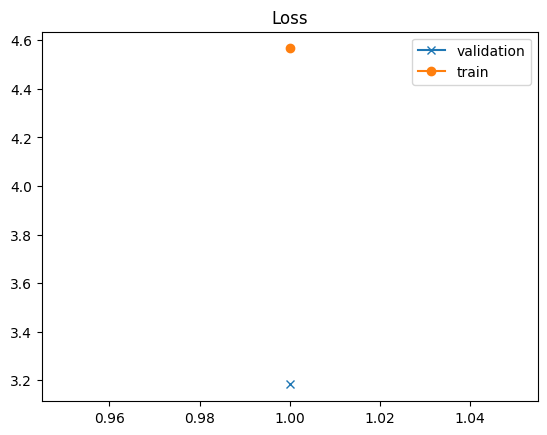

smallest val loss: (1, 3.1827986)

Time taken for this epoch: 66.38 secs

Epoch 2 Batch 0 Loss 3.8067

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good'

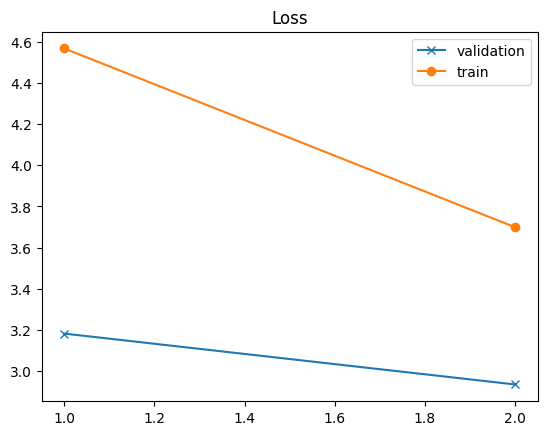

smallest val loss: (2, 2.9358552)

Time taken for this epoch: 5.99 secs

Epoch 3 Batch 0 Loss 3.6329

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good':

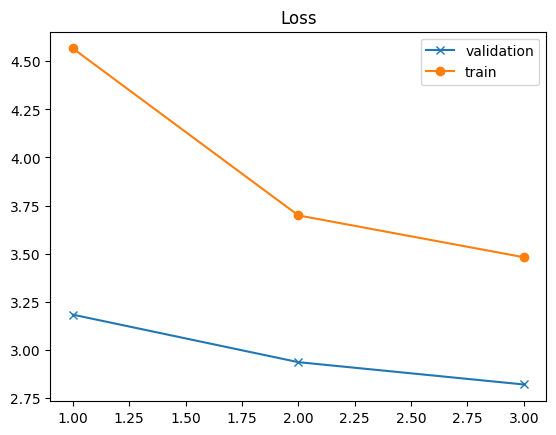

smallest val loss: (3, 2.8198724)

Time taken for this epoch: 6.73 secs

Epoch 4 Batch 0 Loss 3.4974

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good':

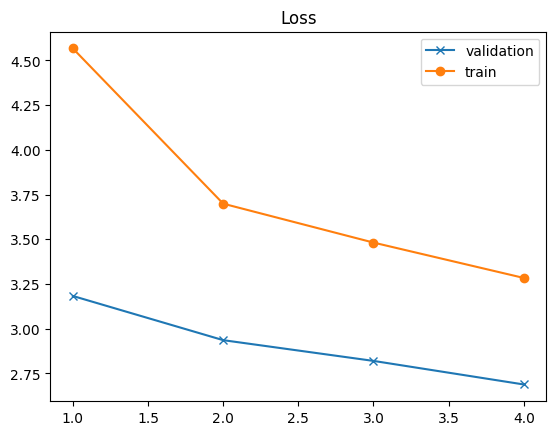

smallest val loss: (4, 2.6881156)

Time taken for this epoch: 5.91 secs

Epoch 5 Batch 0 Loss 2.6800

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good':

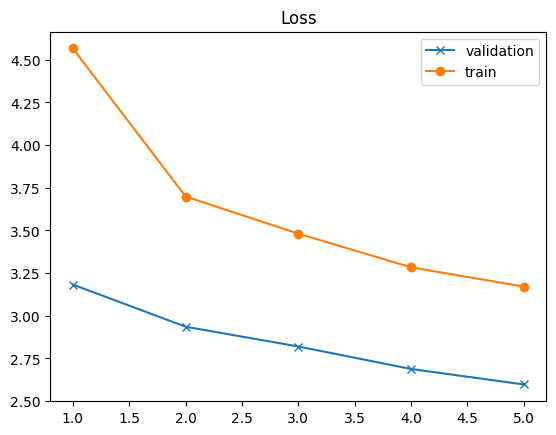

smallest val loss: (5, 2.5973442)

Time taken for this epoch: 6.35 secs

Epoch 6 Batch 0 Loss 2.6316

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good':

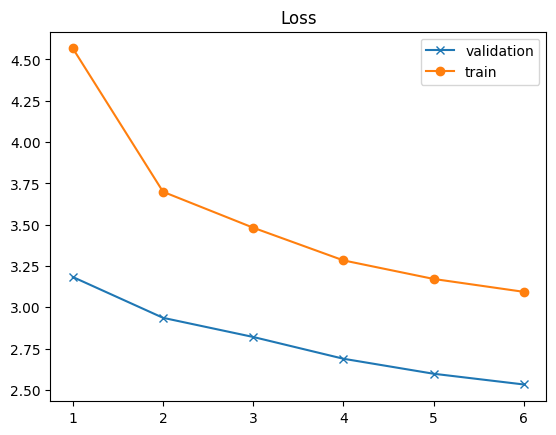

smallest val loss: (6, 2.5323858)

Time taken for this epoch: 5.84 secs

Epoch 7 Batch 0 Loss 3.2302

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good':

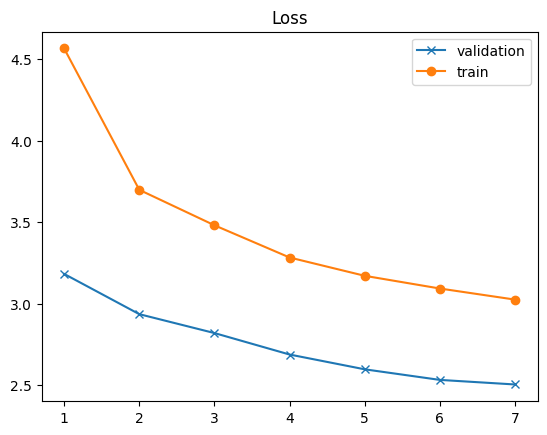

smallest val loss: (7, 2.5043287)

Time taken for this epoch: 6.53 secs

Epoch 8 Batch 0 Loss 2.9281

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good':

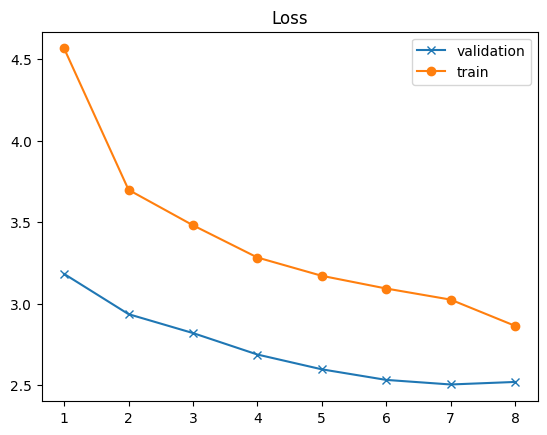

smallest val loss: (7, 2.5043287)

Time taken for this epoch: 5.45 secs

Epoch 9 Batch 0 Loss 2.7604

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good':

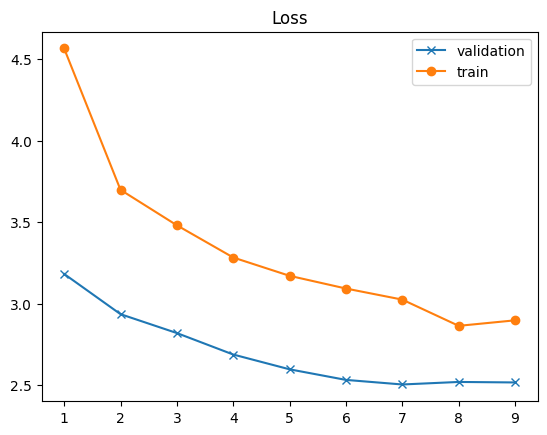

smallest val loss: (7, 2.5043287)

Time taken for this epoch: 6.03 secs

Epoch 10 Batch 0 Loss 2.7300

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good'

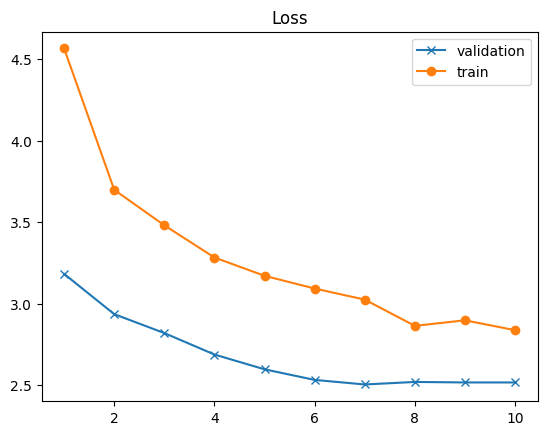

smallest val loss: (7, 2.5043287)

Time taken for this epoch: 9.11 secs

Epoch 11 Batch 0 Loss 2.5994

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good'

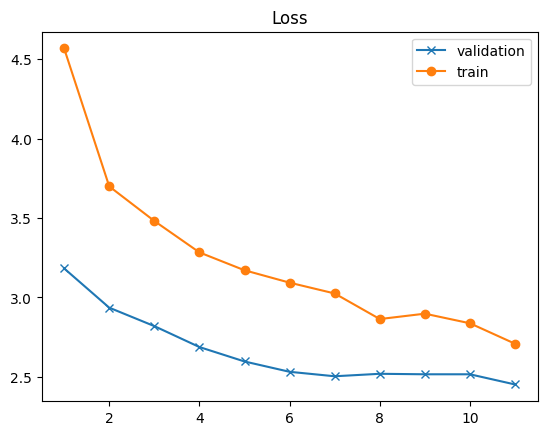

smallest val loss: (11, 2.452655)

Time taken for this epoch: 6.26 secs

Epoch 12 Batch 0 Loss 2.5427

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good'

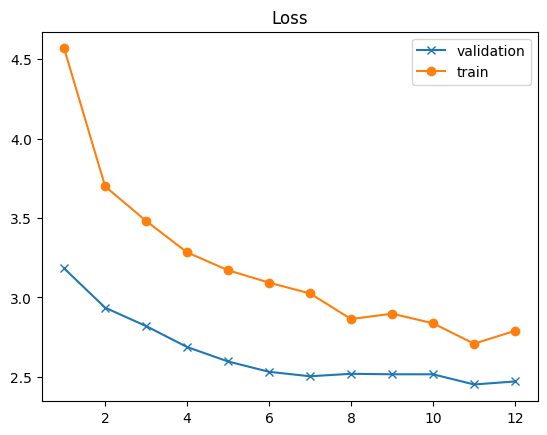

smallest val loss: (11, 2.452655)

Time taken for this epoch: 5.31 secs

Epoch 13 Batch 0 Loss 2.4961

Summary Tokenizer Word Index: {'<UNK>': 1, 'a': 2, 'about': 3, 'adding': 4, 'advantage': 5, 'after': 6, 'ahead': 7, 'alex': 8, 'all': 9, 'am': 10, 'an': 11, 'and': 12, 'another': 13, 'are': 14, 'as': 15, 'at': 16, 'audi': 17, 'back': 18, 'bates': 19, 'bbc': 20, 'be': 21, 'because': 22, 'been': 23, 'before': 24, 'behind': 25, 'being': 26, 'belgian': 27, 'between': 28, 'brew': 29, 'buses': 30, 'but': 31, 'by': 32, 'can': 33, 'car': 34, 'cars': 35, 'changoalverez': 36, 'city': 37, 'clegg': 38, 'cost': 39, 'could': 40, 'crash': 41, 'debut': 42, 'did': 43, 'died': 44, 'dragons': 45, 'driver': 46, 'during': 47, 'each': 48, 'earlier': 49, 'either': 50, 'end': 51, 'even': 52, 'experience': 53, 'fagerson': 54, 'family': 55, 'favaro': 56, 'feel': 57, 'final': 58, 'fire': 59, 'first': 60, 'following': 61, 'for': 62, 'force': 63, 'from': 64, 'fusaro': 65, 'game': 66, 'go': 67, 'going': 68, 'good'

KeyboardInterrupt: ignored

In [48]:
print(params)
print('#'*40)

for epoch in range(ep,100):     #EPOCHS+1):
    ep = epoch
    start = time.time()

    train_loss.reset_states()

    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

        if batch % 200 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch , batch, train_loss.result()))

    print()
    print("Summary Tokenizer Word Index:", summary_tokenizer.word_index)

    print(summarize(clean_words(longreview_val['long'][i1])))
    # print(summarize(clean_words(longreview_val['long'][i2])))
    # print(summarize(clean_words(longreview_val['long'][i3])))
    # print(summarize(clean_words(longreview_val['long'][i4])))
    # print()

    val_loss_ = validate().numpy()
    history['val'].append((epoch,val_loss_))
    print ('\n* Train Loss {:.4f}'.format(train_loss.result()))
    history['train'].append((epoch,train_loss.result().numpy()))


    if best_val_loss-val_loss_ > 0.1:
        ckpt_save_path4 = ckpt_manager4.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path4))
        best_val_loss = val_loss_

    hist(history)
    #print('Current Lr: ',optimizer2._decayed_lr('float32').numpy())
    print ('\nTime taken for this epoch: {:.2f} secs\n'.format(time.time() - start))
    print('='*40)

output removed to reduce file size for github

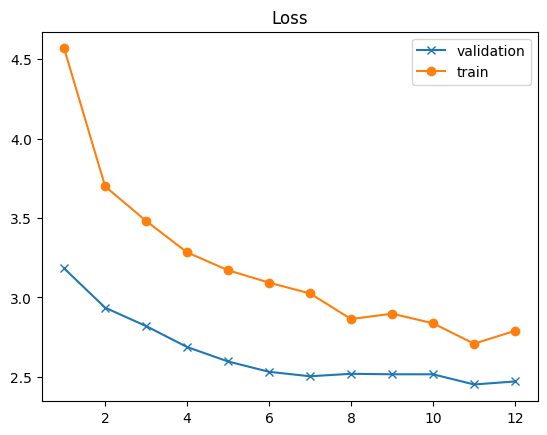

smallest val loss: (11, 2.452655)


{'lmbda_l2': 0.1,
 'd_out_rate': 0.1,
 'num_layers': 4,
 'd_model': 50,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [49]:
hist(history)
params

you can use more data or more regularization to avoid the overfitting

In [55]:
#print(clean_words(longreview_val['long'][i1]))
print()
print(summarize((longreview_train['long'][0])))
#print(summarize(clean_words("the full cost of damage in newton stewart one of the areas worst affected is still being assessed repair work is ongoing in hawick and many roads in peeblesshire remain badly affected by standing water trains on the west coast mainline face disruption due to damage at the lamington viaduct many businesses and householders were affected by flooding in newton stewart after the river cree overflowed into the town first minister nicola sturgeon visited the area to inspect the damage the waters breached a retaining wall flooding many commercial properties on victoria street  the main shopping thoroughfare jeanette tate who owns the cinnamon cafe which was badly affected said she could not fault the multiagency response once the flood hit however she said more preventative work could have been carried out to ensure the retaining wall did not fail it is difficult but i do think there is so much publicity for dumfries and the nith  and i totally appreciate that  but it is almost like we are neglected or forgotten she said")))


<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


In [ ]:
print(clean_words(longreview_val['long'][i2]))
print()
print(summarize(clean_words(longreview_val['long'][i2])))

In [ ]:
print(summarize(("A reverse proxy is a server that sits in front of web servers and forwards client (e.g. web browser) requests to those web servers. Reverse proxies are typically implemented to help increase security, performance, and reliability. In order to better understand how a reverse proxy works and the benefits it can provide, let’s first define what a proxy server is.")))